#Используя подход Нейронных Сетей с библиотекой PyTorch и метод обратного распространения ошибки, была выполнена классификация данных из указанного датасета. Выходными метками (учителями) является столбец/атрибут "outcome". Датасет был рассмотрен на лекции с одним внутренним слоем.

#Были построены две топологии Нейронных Сетей: с 3 внутренними слоями (количество нейронов в каждом слое было подобрано вручную) и с 4 внутренними слоями (количество нейронов также подобрано вручную). Были сравнены значения метрики качества (accuracy) между указанными топологиями.

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [ ]:
#загружаем набор данных
dataset = pd.read_csv('diabetes.csv')
#первые 5 строк
dataset.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
# Выбираем необходимые столбцы
#X = dataset[['Pregnancies', 'Glucose', 'BloodPressure', 'Insulin', 'BMI', 'SkinThickness', 'DiabetesPedigreeFunction', 'Age']]
X = dataset.drop('Outcome', axis=1)
y = dataset['Outcome']

In [ ]:
# Нормализуем данные
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
# Преобразование данных в тензоры
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

In [ ]:
# создание нейронной сети
class NeuralNet3Layers(nn.Module):
    def __init__(self, input_size):

        super(NeuralNet3Layers, self).__init__()
        self.layer1 = nn.Linear(input_size, 16)
        self.layer2 = nn.Linear(16, 8)
        self.layer3 = nn.Linear(8, 4)
        self.output = nn.Linear(4, 1)

        #используем сигмоиду для решения задачи классификации
        self.sigmoid = nn.Sigmoid()

#Определяет, как входные данные будут проходить через слои сети.
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

input_size = X_train.shape[1] # количество признаков в тренировочных данных
model_3 = NeuralNet3Layers(input_size) # экземпляр модели разморностью входных данных

In [ ]:
class NeuralNet4Layers(nn.Module):
    def __init__(self, input_size):
        super(NeuralNet4Layers, self).__init__()
        self.layer1 = nn.Linear(input_size, 32)
        self.layer2 = nn.Linear(32, 16)
        self.layer3 = nn.Linear(16, 8)
        self.layer4 = nn.Linear(8, 4)
        self.output = nn.Linear(4, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = torch.relu(self.layer4(x))
        x = self.sigmoid(self.output(x))
        return x

model_4 = NeuralNet4Layers(input_size)

In [ ]:
# Обучение
def train_model(model, X_train, y_train, num_epochs=100, learning_rate=0.001):

    # используем бинарную кросс-энтропию в качестве функции потерь
    criterion = nn.BCELoss()
    # Оптимизатор для обновления весов
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_values = []

    for epoch in range(num_epochs):
        model.train()

        # обнуляем градиенты перед началом новой итерации.
        optimizer.zero_grad()
        # прямое распространение, чтобы получить предсказания модели для входных данных
        outputs = model(X_train)
        #  значение функции потерь
        loss = criterion(outputs, y_train)
        # выполняем обратное распространение, чтобы вычислить градиенты.
        loss.backward()

        optimizer.step()
        loss_values.append(loss.item())

        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    return loss_values


In [ ]:
#Для оценки производительности
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test)
        predictions = predictions.round()
        accuracy = accuracy_score(y_test, predictions)
    return accuracy

Epoch [10/100], Loss: 0.7389
Epoch [20/100], Loss: 0.7359
Epoch [30/100], Loss: 0.7331
Epoch [40/100], Loss: 0.7304
Epoch [50/100], Loss: 0.7277
Epoch [60/100], Loss: 0.7248
Epoch [70/100], Loss: 0.7214
Epoch [80/100], Loss: 0.7171
Epoch [90/100], Loss: 0.7117
Epoch [100/100], Loss: 0.7054


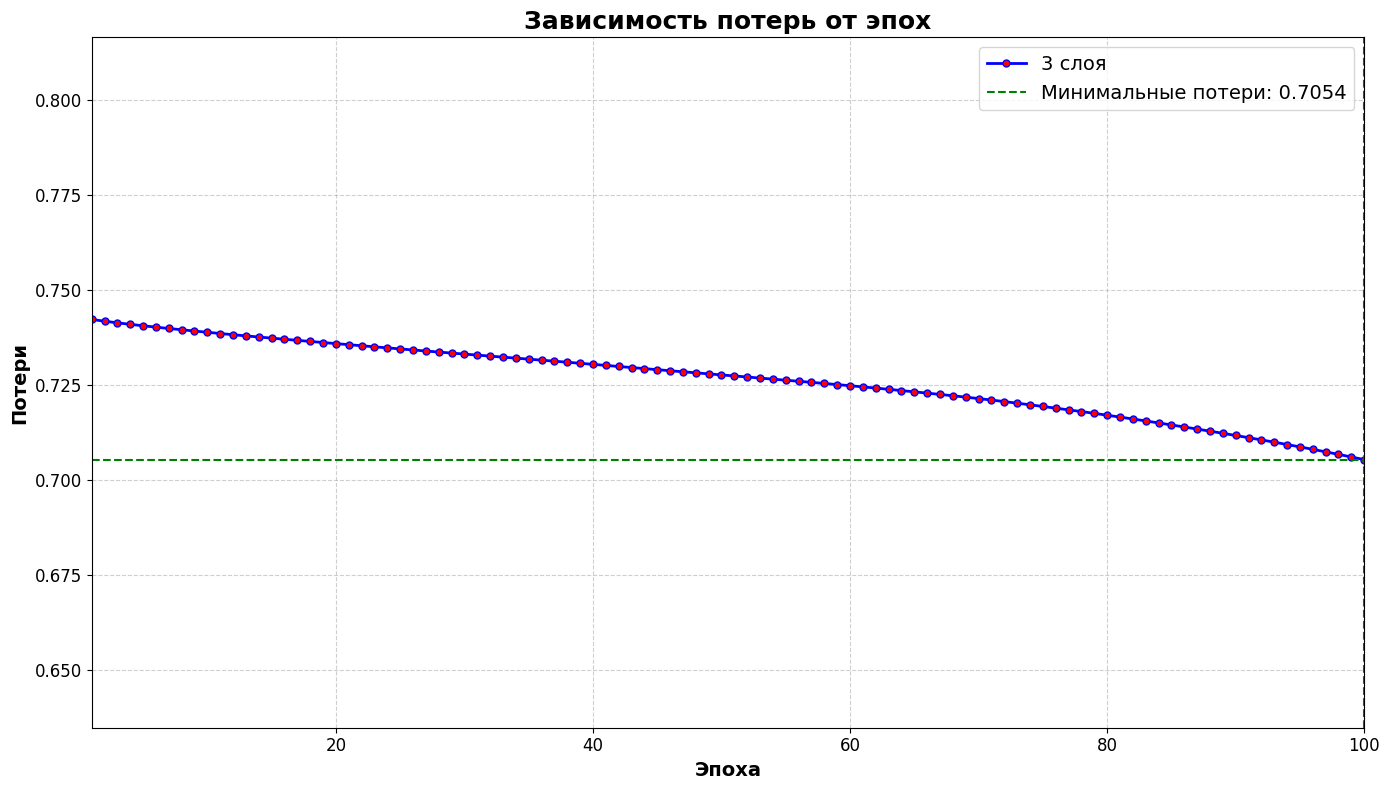

In [ ]:
import matplotlib.pyplot as plt

# Обучение модели с 3 слоями
loss_values3 = train_model(model_3, X_train, y_train)

# Построение графика функции потерь
plt.figure(figsize=(14, 8))
plt.plot(range(1, 101), loss_values3, label='3 слоя', color='blue', linestyle='-', linewidth=2, marker='o', markersize=5, markerfacecolor='red')

plt.xlabel('Эпоха', fontsize=14, fontweight='bold')
plt.ylabel('Потери', fontsize=14, fontweight='bold')
plt.title('Зависимость потерь от эпох', fontsize=18, fontweight='bold')

plt.grid(True, linestyle='--', alpha=0.6)

plt.legend(fontsize=14)

plt.xlim([1, 100])
plt.ylim([min(loss_values3) * 0.9, max(loss_values3) * 1.1])

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axhline(y=min(loss_values3), color='green', linestyle='--', linewidth=1.5, label=f'Минимальные потери: {min(loss_values3):.4f}')
plt.axvline(x=loss_values3.index(min(loss_values3))+1, color='green', linestyle='--', linewidth=1.5)

plt.legend(fontsize=14)
plt.tight_layout()  #
plt.show()


In [ ]:
# Оценка модели с 3 слоями
accu3 = evaluate_model(model_3, X_test, y_test)
print("Точность модели с 3 слоями:", round(accu3, 3))

Точность модели с 3 слоями: 0.383


Epoch [10/100], Loss: 0.6614
Epoch [20/100], Loss: 0.6592
Epoch [30/100], Loss: 0.6577
Epoch [40/100], Loss: 0.6558
Epoch [50/100], Loss: 0.6534
Epoch [60/100], Loss: 0.6500
Epoch [70/100], Loss: 0.6456
Epoch [80/100], Loss: 0.6395
Epoch [90/100], Loss: 0.6312
Epoch [100/100], Loss: 0.6198


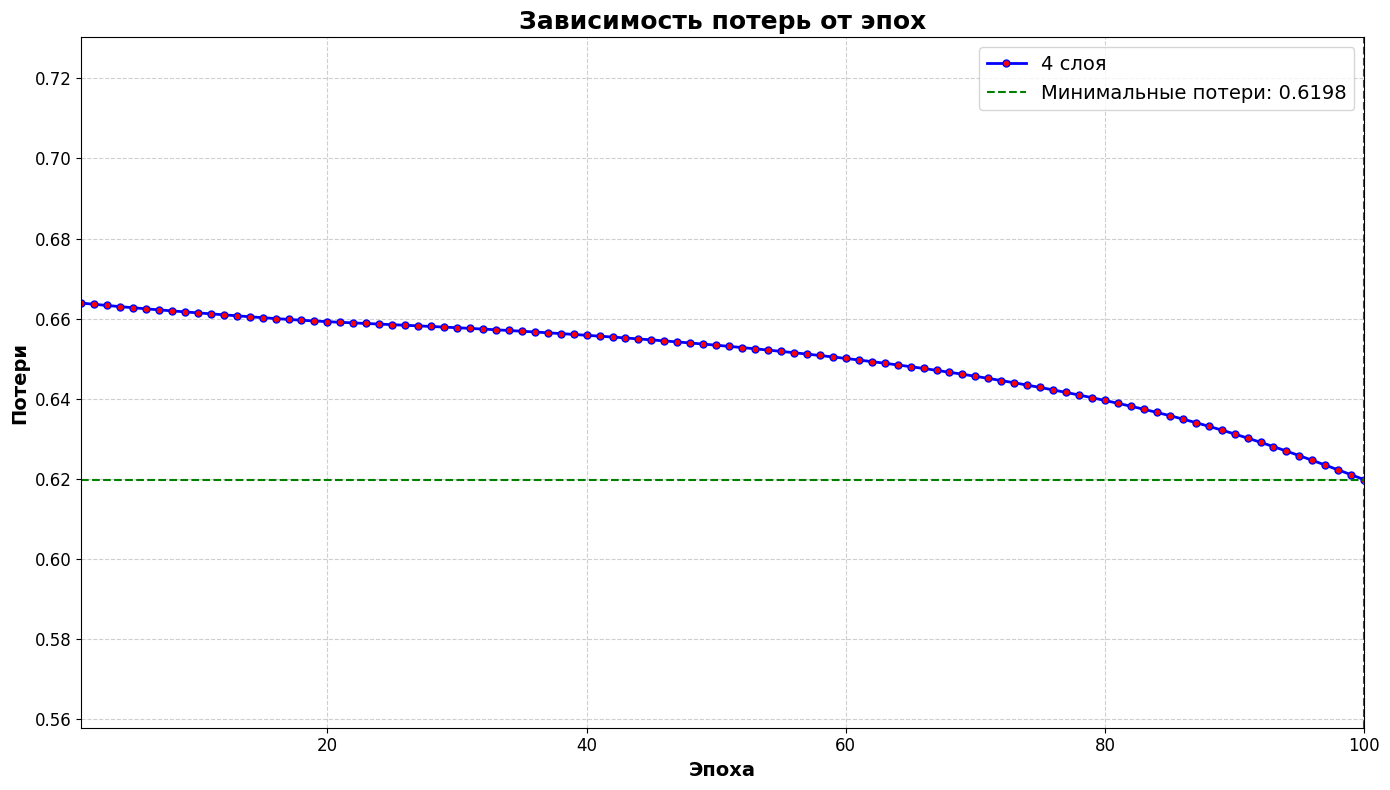

In [ ]:
# Обучение модели с 4 слоями
loss_values4 = train_model(model_4, X_train, y_train)

# Построение графика функции потерь
plt.figure(figsize=(14, 8))
plt.plot(range(1, 101), loss_values4, label='4 слоя', color='blue', linestyle='-', linewidth=2, marker='o', markersize=5, markerfacecolor='red')

plt.xlabel('Эпоха', fontsize=14, fontweight='bold')
plt.ylabel('Потери', fontsize=14, fontweight='bold')
plt.title('Зависимость потерь от эпох', fontsize=18, fontweight='bold')

plt.grid(True, linestyle='--', alpha=0.6)

plt.legend(fontsize=14)

plt.xlim([1, 100])
plt.ylim([min(loss_values4) * 0.9, max(loss_values4) * 1.1])

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axhline(y=min(loss_values4), color='green', linestyle='--', linewidth=1.5, label=f'Минимальные потери: {min(loss_values4):.4f}')
plt.axvline(x=loss_values4.index(min(loss_values4))+1, color='green', linestyle='--', linewidth=1.5)

plt.legend(fontsize=14)

plt.tight_layout()
plt.show()

In [ ]:
# Оценка модели с 3 слоями
accu4 = evaluate_model(model_4, X_test, y_test)
print("Точность модели с 4 слоями:", round(accu4, 3))

Точность модели с 4 слоями: 0.792
